In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="Real stock price")
    plt.plot(predicted, color="blue", label="Predicted stock price")
    plt.title("Stock price prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock price")
    plt.legend()
    plt.show()

In [4]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [5]:
data = pd.read_csv(r'C:/Users/yaman/OneDrive/Documents/SET Conference/SET2/Datasets/ApplePrice.csv', index_col='Date', parse_dates=["Date"])

In [6]:
data.shape

(4029, 6)

In [7]:
data

,Price,Open,High,Low,Volume (in M),Chg%
Date,,,,,,
"Jan 03, 2007",2.99,3.08,3.09,2.92,1.25,-1.32
"Jan 04, 2007",3.06,3.00,3.07,2.99,856.13,2.34
"Jan 05, 2007",3.04,3.06,3.08,3.01,835.40,-0.65
"Jan 08, 2007",3.05,3.07,3.09,3.05,797.73,0.33
"Jan 09, 2007",3.31,3.09,3.32,3.04,3.35,8.52
...,...,...,...,...,...,...
"Dec 23, 2022",131.86,130.92,132.41,129.64,63.82,-0.28
"Dec 27, 2022",130.03,131.38,131.41,128.72,68.75,-1.39
"Dec 28, 2022",126.04,129.67,131.03,125.87,84.90,-3.07


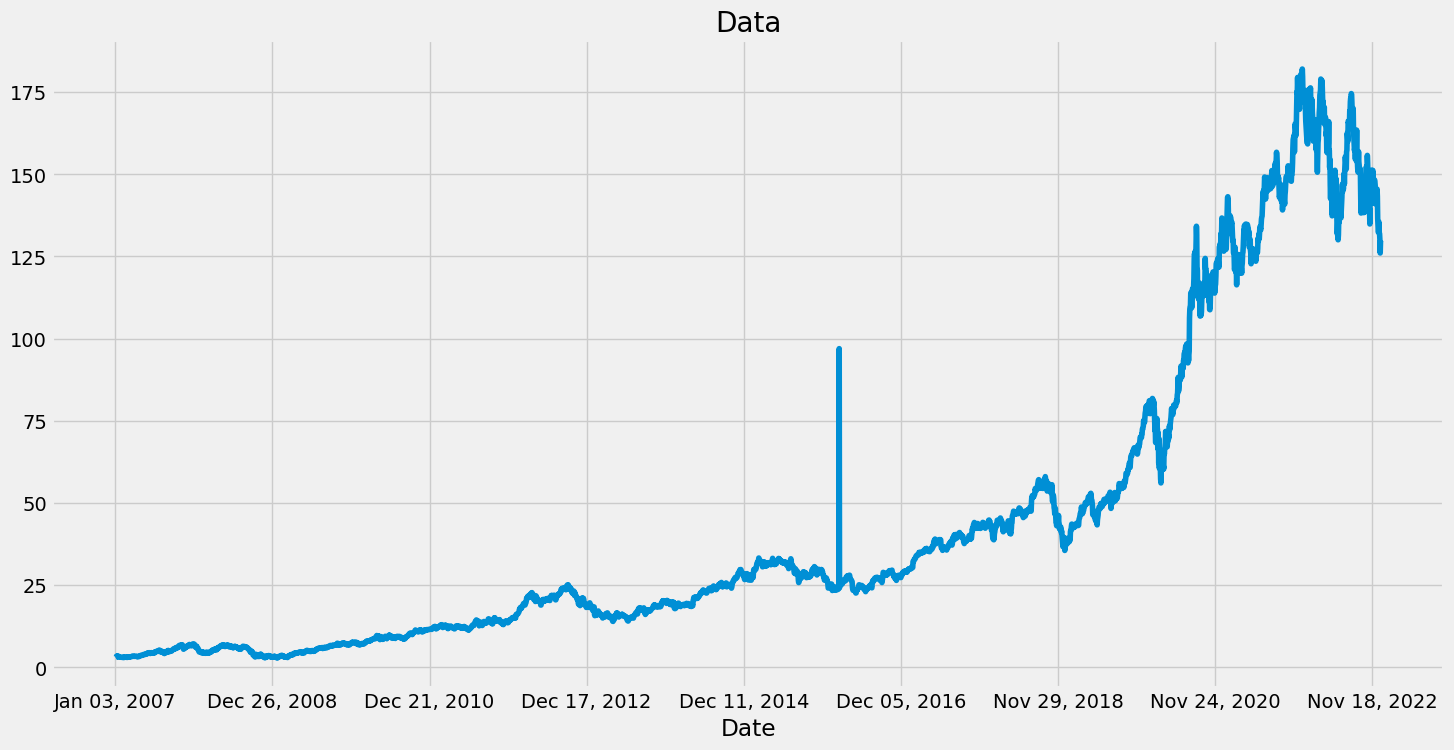

In [8]:
data["Price"].plot(figsize=(16,8))
plt.title("Data")
plt.show()

In [9]:
train = data[:'Dec 31, 2019'].iloc[:,1:2].values
test = data['Jan 02, 2020':].iloc[:,1:2].values

In [10]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [11]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2769):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
x_train[0]

array([0.00255021, 0.00170014, 0.00233769, 0.00244395, 0.00265647,
       0.00573797, 0.00626926, 0.00573797, 0.006163  , 0.00680055,
       0.00478164, 0.00350653, 0.00361279, 0.00233769, 0.00276272,
       0.00286898, 0.00286898, 0.00255021, 0.00265647, 0.00201891,
       0.00255021, 0.00170014, 0.0018064 , 0.00191266, 0.00191266,
       0.00223143, 0.00244395, 0.00191266, 0.00212517, 0.00191266,
       0.00223143, 0.00212517, 0.00191266, 0.00244395, 0.00425035,
       0.00361279, 0.00393157, 0.00255021, 0.0012751 , 0.00170014,
       0.00276272, 0.00244395, 0.00318776, 0.00318776, 0.00340028,
       0.00350653, 0.00329402, 0.00371905, 0.00340028, 0.00393157,
       0.00382531, 0.00403783, 0.00446286, 0.00478164, 0.00541919,
       0.00520667, 0.00552545, 0.006163  , 0.00584422, 0.00552545])

In [13]:
y_train[0]

0.005631707576240569

In [14]:
len(x_train)

2709

In [15]:
len(y_train)

2709

In [16]:
x_train.shape

(2709, 60)

In [17]:
y_train.shape

(2709,)

In [18]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
x_train.shape

(2709, 60, 1)

In [20]:
input_shape = ()

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1],1), 
               recurrent_activation='sigmoid', 
               activation='tanh', 
               implementation=2,
               recurrent_dropout=0.2, 
               return_sequences=True))
model.add(LSTM(64, activation='tanh', 
               recurrent_activation='sigmoid',
               implementation=2, 
               recurrent_dropout=0.2, 
               return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# compiling the model

model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

model.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
19/19 [==============================] - 13s 277ms/step - loss: 0.0013
Epoch 2/5
19/19 [==============================] - 5s 275ms/step - loss: 8.0372e-04
Epoch 3/5
19/19 [==============================] - 5s 274ms/step - loss: 4.5075e-04
Epoch 4/5
19/19 [==============================] - 5s 279ms/step - loss: 3.6385e-04
Epoch 5/5
19/19 [==============================] - 5s 274ms/step - loss: 3.4107e-04


In [28]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 'High' attribute data for processing

dataset_total = pd.concat((data['Price'][:'Dec 31, 2019'], data['Price']['Jan 02, 2020':]), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)

(4029,)
(816,)
(816, 1)
(816, 1)


In [29]:
# preparing x_test

x_test = []
for i in range(60,816):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
# predicting the stock prices for test set

predicted = model.predict(x_test)
predicted = sc.inverse_transform(predicted)

24/24 [==============================] - 2s 26ms/step


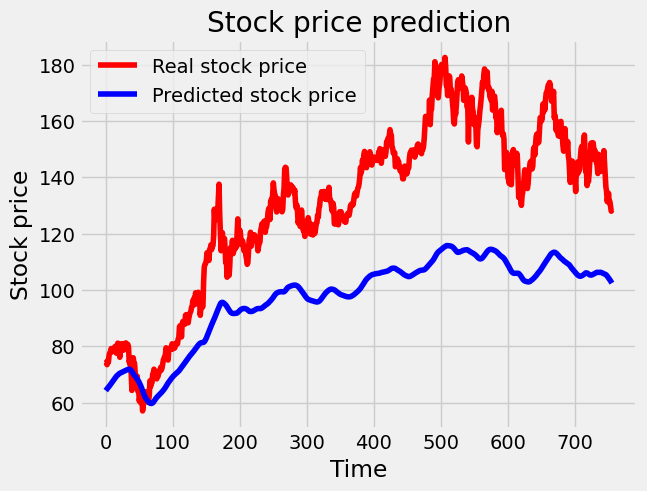

In [31]:
# visualizing the results: predicted vs test

plot_predictions(test, predicted)

In [32]:
return_rmse(test, predicted)

the root mean squared error is : 36.85358816862903.


In [33]:
mean_absolute_percentage_error(test, predicted)

0.23887552736028347